In [1]:
import pandas as pd
import numpy as np
import io
import requests
import os.path
from matplotlib import pyplot as plt
from datetime import datetime as dt
% matplotlib inline

In [2]:
random_state = 43

Task:

Build a classifier over FCA method and compare it to the common algorithms.

I've chosen banknote authentication Data Set https://archive.ics.uci.edu/ml/datasets/banknote+authentication

Number of instances: 1372

Train: 75%, Test: 25%

4 real attributes

1 binary target


Using histogram I got tresholds to transform real attributes to binary. 
Each instance calculate votes for class "+" and for class "-". 

if $votes$"+"==0 and $votes$"-"==0, there is no prediction for such instance.
if $\frac{votes"+"}{(1 + votes"-")} < tau$ this instance belongs to class +, otherwise - to class -.
$tau$ - is a hyperparameter.

In [3]:
if not os.path.exists("data.csv"):
    url="https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
    s=requests.get(url).content
    c=pd.read_csv(io.StringIO(s.decode('utf-8')), names=["variance", "skewness", "curtosis", "entropy", "forgery"])
    c.to_csv("data.csv")

In [4]:
data = pd.read_csv("data.csv", index_col=0)
data.head()

,variance,skewness,curtosis,entropy,forgery
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [5]:
data.shape

(1372, 5)

In [6]:
def show_hist_par(data, column):
    plt.hist(data[data["forgery"] == 0][column], color="r", alpha=0.5)
    plt.hist(data[data["forgery"] == 1][column], color="b", alpha=0.5)
    plt.title(column)
    plt.show()

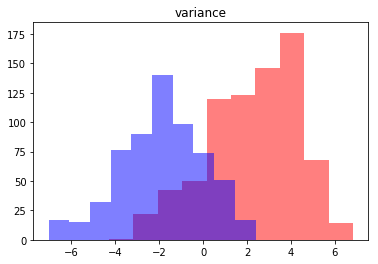

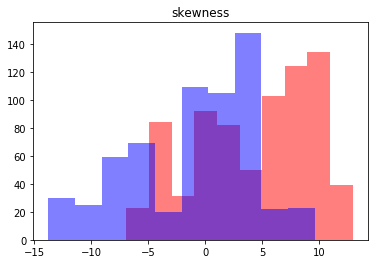

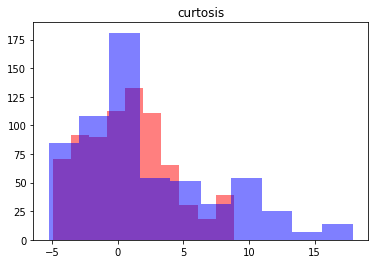

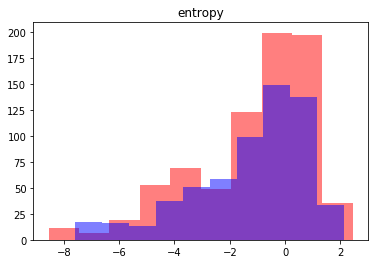

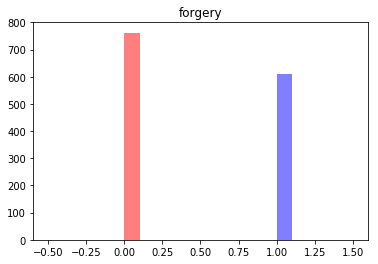

In [7]:
for i in data.columns:
    show_hist_par(data, i)

# Scaling

In [8]:
variance_border = 0
skewness_border_1 = -2.5
skewness_border_2 = 5
curtosis_border_1 = 2
curtosis_border_2 = 8
entropy_border = -1.5

In [9]:
X = pd.DataFrame()
X["variance_l"] = 1 * (data["variance"] < variance_border)
X["variance_h"] = 1 * (data["variance"] >= variance_border)
X["skewness_l"] = 1 * (data["skewness"] < skewness_border_1)
X["skewness_m"] = 1 * (skewness_border_1 <= data["skewness"]) * (data["skewness"] < skewness_border_2)
X["skewness_h"] = 1 * (data["skewness"] >= skewness_border_2)
X["curtosis_l"] = 1 * (data["curtosis"] < curtosis_border_1)
X["curtosis_m"] = 1 * (data["curtosis"] >= curtosis_border_1) * (data["curtosis"] < curtosis_border_2)
X["curtosis_h"] = 1 * (data["curtosis"] >= curtosis_border_2)
X["entropy_l"] = 1 * (data["entropy"] < entropy_border)
X["entropy_h"] = 1 * (data["entropy"] >= entropy_border)
X.head()

,variance_l,variance_h,skewness_l,skewness_m,skewness_h,curtosis_l,curtosis_m,curtosis_h,entropy_l,entropy_h
0,0,1,0,0,1,1,0,0,0,1
1,0,1,0,0,1,1,0,0,0,1
2,0,1,1,0,0,1,0,0,0,1
3,0,1,0,0,1,1,0,0,1,0
4,0,1,1,0,0,0,1,0,0,1


In [10]:
y = data["forgery"].values

# common models (Linear, Tree, KNN)

In [11]:
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

In [13]:
class Classifier:
    untrained_classifier = None
    classifier = None
    y_pred = None
    recall = None
    precision = None
    accuracy = None
    name = None
    _round_digits = 3
    
    def __init__(self, classifier, name):
        self.untrained_classifier = classifier
        self.name = name
        
    def train(self, X_train, y_train):
        t = dt.now()
        self.classifier = self.untrained_classifier.fit(X_train, y_train)
        self.train_time = (dt.now() - t).microseconds
        return self
    
    def calc_metrics(self, X_test, y_test):
        self.y_pred = self.classifier.predict(X_test)
        self.recall = round(recall_score(self.y_pred, y_test), ndigits=self._round_digits)
        self.precision = round(precision_score(self.y_pred, y_test), ndigits=self._round_digits)
        self.accuracy = round(accuracy_score(self.y_pred, y_test), ndigits=self._round_digits)
        return self
        
    def __str__(self):
        return f"""classifier: {self.name}, 
recall: {self.recall}, 
precision: {self.precision}, 
accuracy: {self.accuracy}\n
"""
    
    def __repr__(self):
        return f"model {self.name}"
    
    def get_metrics(self):
        return [self.name, self.recall, self.precision, self.accuracy, self.train_time]

In [14]:
clss = [
    Classifier(RidgeClassifier(), "ridge"),
    Classifier(KNeighborsClassifier(), "knn"),
    Classifier(DecisionTreeClassifier(), "tree")
]

In [15]:
[(x.train(X_train, y_train)
     .calc_metrics(X_test, y_test))
    for x in clss]

[model ridge, model knn, model tree]

# calculate metrics

In [16]:
metrics = pd.DataFrame([x.get_metrics() for x in clss], columns=["classifier", "recall", "precision", "accuracy", "train_time, ms"])
metrics

,classifier,recall,precision,accuracy,"train_time, ms"
0,ridge,0.875,0.851,0.883,4475
1,knn,0.889,0.919,0.915,1844
2,tree,0.960,0.818,0.907,908


# FCA

In [17]:
class_0 = X_train[y_train==0]
class_1 = X_train[y_train==1]
class_0.shape, class_1.shape

((567, 10), (462, 10))

In [18]:
class Votes:
    def __init__(self, class_0, class_1, draw, no_votes):
        self.draw = draw
        self.class_0 = class_0
        self.class_1 = class_1
        self.no_votes = no_votes
    
    def __str__(self):
        return f"+: {self.class_0}\n-: {self.class_1}\n=: {self.draw}\nx: {self.no_votes}\n"
    
    def __repr__(self):
        return str(self)

def make_voiting(test_input_x, class_0, class_1, X_all, min_votes=5, min_difference=5):
    for_class_0 = 0
    for_class_1 = 0
    no_votes = 0
    draw = 0
    
    for i in range(X_all.shape[0]):
        
        base = test_input_x * X_all.iloc[i, :]
        g_plus = 1 * (class_0 >= base).min(axis=1).sum()
        g_minus = 1 * (class_1 >= base).min(axis=1).sum()
        if g_plus < min_votes and g_plus < min_votes:
            no_votes += 1
        elif abs(g_plus - g_minus) < min_difference:
            draw += 1
        elif g_plus > g_minus:
            for_class_0 +=1
        else:
            for_class_1 += 1
    
    return Votes(for_class_0, for_class_1, draw, no_votes)

In [127]:
class FCAClassifier:
    y_prepred = []
    y_test = []
    
    def __init__(self, class_0, class_1):
        self.class_0 = class_0
        self.class_1 = class_1
        self.all_data = pd.concat([class_0, class_1])
    
    def evaluater_prepredictions(self, test_data, smooth_parameter=1):
        all_data = self.all_data.copy()
        class_0 = self.class_0.copy()
        class_1 = self.class_1.copy()
        result = []
        t = dt.now()
        for i in range(test_data.shape[0]):
            if i % 100 == 0:
                print(f"iteraction {i}/{test_data.shape[0]}, time: {str(dt.now())}")
            x = test_data.iloc[i, :]
            votes =  make_voiting(x, class_0, class_1, all_data)
            result.append( -1 
                          if votes.class_0 == 0 and votes.class_1 == 0
                          else
                          votes.class_0 / (votes.class_1 + smooth_parameter)
            )
            self.y_prepred = np.array(result)
        self.train_time = (dt.now() - t).microseconds
    
    def calc_y_pred(self, tau):
        self.y_pred = 1 * (self.y_prepred < tau)
        self.y_pred[self.y_prepred < 0] = -1
    
    def caclulate_metrics(self, tau):
        self.calc_y_pred(tau)
        
        self.precision = precision_score(self.y_test, self.y_pred)
        self.accuracy = accuracy_score(self.y_test, self.y_pred)
        self.recall = recall_score(self.y_test, self.y_pred)
        return 1./3 *(self.precision + self.accuracy  + self.recall)

In [128]:
class FCAClassifierContinious:
    y_prepred = []
    y_test = []
    
    def __init__(self, class_0, class_1):
        self.class_0 = class_0
        self.class_1 = class_1
        self.all_data = pd.concat([class_0, class_1])
        
    def evaluater_prepredictions_continiously(self, test_data, smooth_parameter=1):
        all_data = self.all_data.copy()
        class_0 = self.class_0.copy()
        class_1 = self.class_1.copy()
        
        result = []
        t = dt.now()
        for i in range(test_data.shape[0]):
            if i % 100 == 0:
                print(f"iteraction {i}/{test_data.shape[0]}, time: {str(dt.now())}")
            x = test_data.iloc[i, :]
            votes =  make_voiting(x, class_0, class_1, all_data)
            
            result.append( -1 
                          if votes.class_0 == 0 and votes.class_1 == 0
                          else
                          votes.class_0 / (votes.class_1 + smooth_parameter)
            )
            all_data.append(x)
            class_1.append(x) if y_test[i] else class_0.append(x)
        self.y_prepred = np.array(result)
        self.train_time = (dt.now() - t).microseconds
            
    
    def calc_y_pred(self, tau):
        self.y_pred = 1 * (self.y_prepred < tau)
        self.y_pred[self.y_prepred < 0] = -1
    
    def caclulate_metrics(self, tau):
        self.calc_y_pred(tau)
        
        self.precision = precision_score(self.y_test, self.y_pred)
        self.accuracy = accuracy_score(self.y_test, self.y_pred)
        self.recall = recall_score(self.y_test, self.y_pred)
        return 1./3 *(self.precision + self.accuracy  + self.recall)

In [129]:
cl = FCAClassifier(class_0, class_1)

In [130]:
cl.evaluater_prepredictions(X_test)

iteraction 0/343, time: 2018-12-15 23:45:20.652213
iteraction 100/343, time: 2018-12-15 23:47:18.908740
iteraction 200/343, time: 2018-12-15 23:49:17.390320
iteraction 300/343, time: 2018-12-15 23:51:13.402851


In [84]:
clc = FCAClassifierContinious(class_0, class_1)

In [85]:
clc.evaluater_prepredictions_continiously(X_test)

iteraction 0/343, time: 2018-12-15 22:52:22.009378
iteraction 100/343, time: 2018-12-15 22:54:10.007076
iteraction 200/343, time: 2018-12-15 22:55:57.668023
iteraction 300/343, time: 2018-12-15 22:57:45.214716


In [137]:
cl.y_test = y_test
clc.y_test = y_test

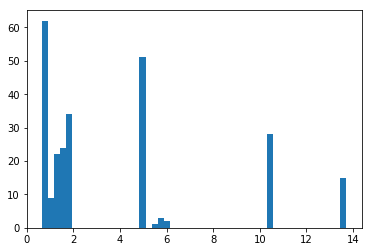

In [138]:
# гистрограмма значений классификатора votes+ / (1+votes-)
plt.hist(cl.y_prepred[cl.y_prepred < 1000], bins=50);

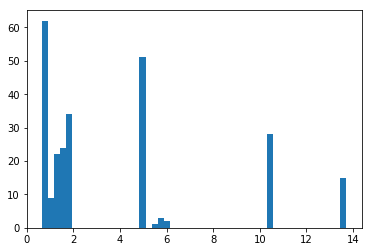

In [139]:
# гистрограмма значений классификатора для continious
plt.hist(clc.y_prepred[clc.y_prepred < 1000], bins=50);

In [140]:
def draw_metrics(classifier, tau_max=18, density=100):
    metrics_x = []
    metrics_recall = []
    metrics_accuracy = []
    metrics_precision = []
    steps_per_unit = density

    for tau_i in range(0, tau_max*steps_per_unit):
        tau = 1. * tau_i / steps_per_unit
        metrics_x.append(tau)
        classifier.caclulate_metrics(tau)
        metrics_recall.append(classifier.recall)
        metrics_accuracy.append(classifier.accuracy)
        metrics_precision.append(classifier.precision)

    plt.plot(metrics_x, metrics_recall, c="r")
    plt.plot(metrics_x, metrics_accuracy, c="b")
    plt.plot(metrics_x, metrics_precision, c="g")
    plt.title("metrics <-> tau")
    plt.xlabel("tau")
    plt.ylabel("metric")
    plt.show();

# precision, recall and accuracy for different values of tau
general and continious method


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


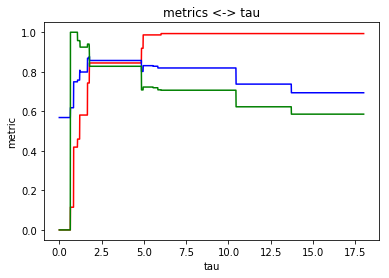

In [141]:
draw_metrics(cl)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


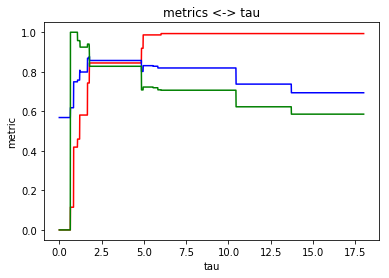

In [142]:
# continious case
draw_metrics(clc)

In [143]:
best_tau_1 = 3
cl.caclulate_metrics(best_tau_1)

0.8431840070912919

In [144]:
best_tau_cont = 6
clc.caclulate_metrics(best_tau_cont)

0.8381554443571484

In [145]:
metrics.loc[3] = ["fca", cl.recall, cl.precision, cl.accuracy, cl.train_time]
metrics.loc[4] = ["fca_cont", clc.recall, clc.precision, clc.accuracy, clc.train_time]

# final metrics comparation

In [146]:
metrics

,classifier,recall,precision,accuracy,"train_time, ms"
0,ridge,0.875000,0.851000,0.883000,4475
1,knn,0.889000,0.919000,0.915000,1844
2,tree,0.960000,0.818000,0.907000,908
3,fca,0.844595,0.827815,0.857143,773936
4,fca_cont,0.986486,0.708738,0.819242,291426


# Use same approach for iris, 1-st and 2-nd types

In [147]:
% run load_iris.ipynb

In [148]:
X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(X_iris, y_iris, random_state=random_state)

In [149]:
iris_0 = X_iris_train[y_iris_train==0]
iris_1 = X_iris_train[y_iris_train==1]
iris_0.shape, iris_1.shape

((36, 8), (39, 8))

In [150]:
cl_iris = FCAClassifier(iris_0, iris_1)

In [151]:
cl_iris.evaluater_prepredictions(X_iris_test)

iteraction 0/25, time: 2018-12-16 00:11:09.946052


In [152]:
cl_iris.y_test = y_iris_test

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


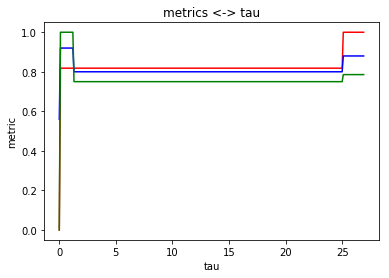

In [153]:
draw_metrics(cl_iris, 27, 10)

0.7893939393939393

In [168]:
metrics_iris = pd.DataFrame(columns=["tau", "recall", "precision", "accuracy"])

In [169]:
cl_iris.caclulate_metrics(best_tau_1)
metrics_iris.loc[0] = ["banknote value", cl_iris.recall, cl_iris.precision, cl_iris.accuracy]

In [170]:
best_tau_iris = 26

In [171]:
cl_iris.caclulate_metrics(best_tau_iris)
metrics_iris.loc[1] = ["optimal value", cl_iris.recall, cl_iris.precision, cl_iris.accuracy]

In [172]:
metrics_iris

,tau,recall,precision,accuracy
0,banknote value,0.818182,0.750000,0.80
1,optimal value,1.000000,0.785714,0.88
